In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

beta = 50
PATH = "/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/"

In [7]:
foldername = [
  "/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/SrVO3/",
  "/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/SrMoO3/",
  "/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/SrMoO3_J0/",
  "/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/SrVO3_DFT/",
  "/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/SrVO3_DFTUw/",
  ]
filename = [
  "SrVO3_3-2025-09-15-Mon-13-15-43.hdf5",
  "SrMoO3_4-2025-09-15-Mon-13-37-52.hdf5",
  "SrMoO3_5-2025-09-16-Tue-09-19-10.hdf5",
  "SrVO3_4-2025-09-14-Sun-22-18-58.hdf5",
  "SrVO3_3-2025-09-14-Sun-23-01-37.hdf5"
  ]
figname = [
    "SrVO3", 
    "SrMoO3", 
    "SrMoO3_J0", 
    "SrVO3_DFT", 
    "SrVO3_DFTUw", 
]
savename = [
    "SrVO3.dat",
    "SrMoO3.dat",
    "SrMoO3_J0.dat", 
    "SrVO3_DFT.dat", 
    "SrVO3_DFTUw.dat", 
]
double_occ = [
    0.0059291, 
    0.00583453, 
    0.00591875, 
    0.0562733,
    0.0562733,
    0.0562733,
    0.0617116,
    0.0617116,
    0.0617116,
    0.00313182,
    0.00313182,
    0.00313182,
    0.00378062,
    0.00378062,
    0.00378062,
]
double_occ = np.array(double_occ)

sztau_filename = "sztau.dat"
ntau11_filename = "ntau1111.dat"
ntau12_filename = "ntau1112.dat"

giws = []
siws = []
popt2s = []
iwmaxs = []
iw0s = []
ivs = []


### Setting different noise levels for the two compounds...
# for n in range(0,len(foldername)-1):
with h5py.File(PATH+"data_collection.h5", "w") as fw:
    for n in range(0,len(foldername)):
        print(foldername[n])

        grp = fw.create_group(figname[n])

        with h5py.File(foldername[n]+filename[n], "r") as f:
            iv = np.array(f['.axes']['iw'][:])
            tau = np.array(f['.axes']['tau'][:])
            gtau = np.array(f['dmft-last']['ineq-001']['gtau']['value'])
            giw = np.array(f['dmft-last']['ineq-001']['giw']['value'])
            siw = np.array(f['dmft-last']['ineq-001']['siw']['value'])
            giws.append(siw)
            siws.append(siw)
            ivs.append(iv)

        sztau = np.loadtxt(foldername[n]+sztau_filename, usecols=[1,2,3])
        ntau11 = np.loadtxt(foldername[n]+ntau11_filename, usecols=[5,6,7])
        ntau12 = np.loadtxt(foldername[n]+ntau12_filename, usecols=[5,6,7])
        ntau11 = np.array(ntau11)
        ntau11 = ntau11[:,2] - double_occ[3*n]

        dset1 = grp.create_dataset("iv", data=iv)
        dset1 = grp.create_dataset("tau", data=tau)
        dset1 = grp.create_dataset("gtau", data=gtau)
        dset1 = grp.create_dataset("giv", data=giw)
        dset1 = grp.create_dataset("siv", data=siw)
        dset1 = grp.create_dataset("sztau", data=sztau)
        dset1 = grp.create_dataset("ntau11", data=ntau11)
        dset1 = grp.create_dataset("ntau12", data=ntau12)
        dset1 = grp.create_dataset("beta", data=beta)
fw.close()


/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/SrVO3/
/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/SrMoO3/
/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/SrMoO3_J0/
/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/SrVO3_DFT/
/mnt/scratch/daniel/Data/DynamicalU_Susceptibility/MATERIALS-with-Uw/SrVO3_DFTUw/


In [ ]:
import ana_cont.continuation as cont
import numpy as np
import h5py

noise_amplitude = 1e-3
v_max = 300
w = np.linspace(-20., 20., num=501, endpoint=True)

with h5py.File(PATH+"data_collection.h5", "r+") as f:  # read+write
    for n, ff in enumerate(f.keys()):
        print(ff)
        grp = f[ff]  # reference the existing group
        grpaw = grp.create_group("Aw")

        iv = grp["iv"][:]
        beta = grp["beta"][()]
        giv = grp["giv"]  # shape should be (orbital, freq) or similar
        wn = np.pi / beta * (2.*np.arange(v_max) + 1.)

        for o in range(3):
            print(o)
            probl = cont.AnalyticContinuationProblem(
                im_axis=iv[1000:1000+v_max],
                re_axis=w,
                im_data=giv[o, 0, 1000:1000+v_max],
                kernel_mode='freq_fermionic'
            )

            err = np.ones_like(wn) * noise_amplitude
            model = np.ones_like(w)
            model /= np.trapz(model, w)

            sol, _ = probl.solve(
                method='maxent_svd',
                alpha_determination='chi2kink',
                optimizer='newton',
                stdev=err,
                model=model
            )

            # store inside the same group
            # dset_name = f"Aw_{o}"
            # if dset_name in grp:
            #     del grp[dset_name]
            grpaw.create_dataset(str(o), data=sol.A_opt)
        grp.create_dataset("w", data=w)


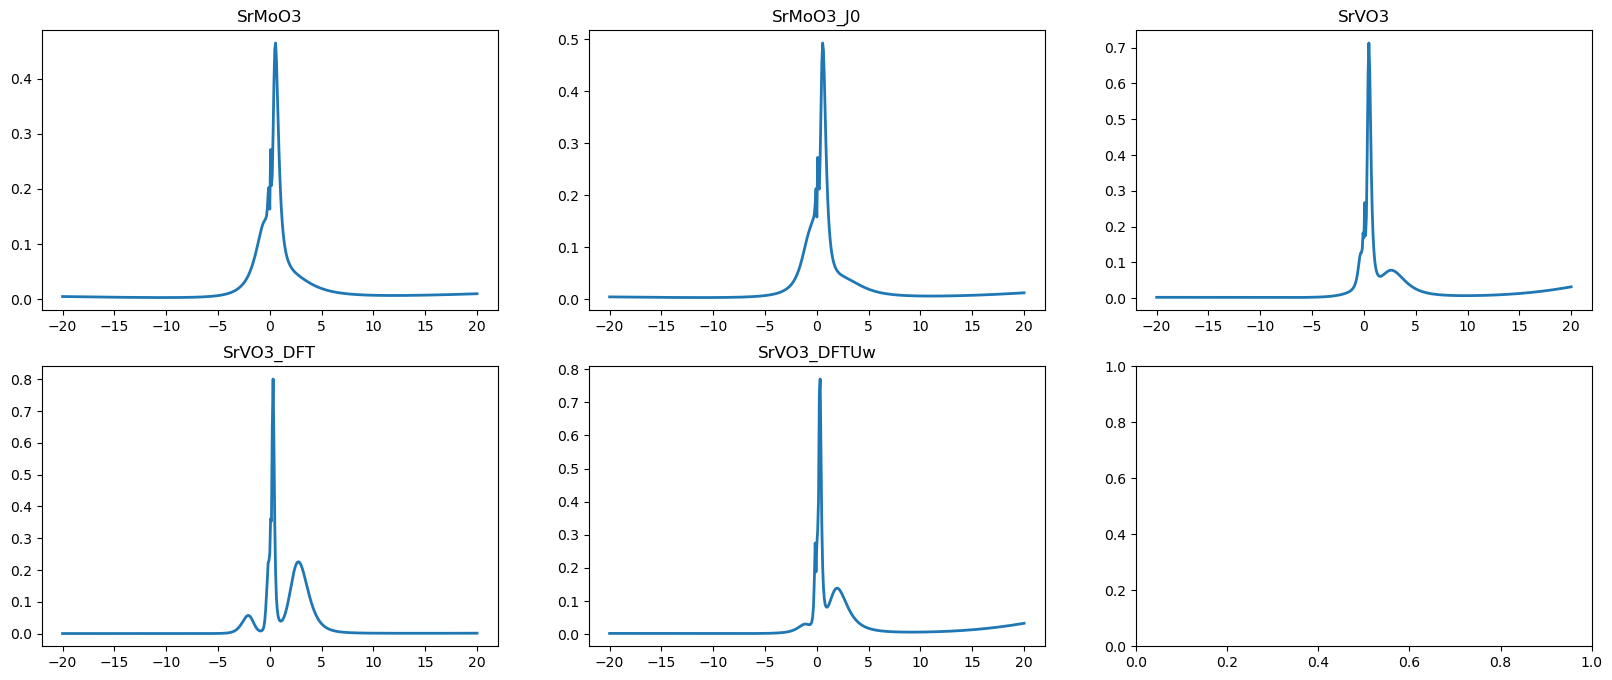

In [ ]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
c = 0
r = 0
with h5py.File(PATH+"data_collection.h5", "r") as f:
    for n, ff in enumerate(f.keys()):
        for o in range(1):
            ax[r,c].plot(f[ff]["w"][:], f[ff]["Aw/"+str(o)][:].real, linewidth="2")
        ax[r,c].set_title(ff)
        c += 1
        if c == 3:
            r += 1
            c = 0
